In [ ]:
import tensorflow as tf
import yfinance as yf
from yahoo_fin.stock_info import get_data
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

In [4]:
# Imports 3 years of BTC daily data from yahoo finance
ETH_df = get_data("ETH-USD", start_date="6/30/2019", end_date="06/30/2022", index_as_date = True, interval="1d")
df = ETH_df.iloc[:,0:-1]
df.head()

,open,high,low,close,adjclose,volume
2019-06-30,319.584045,322.789581,290.695984,290.695984,290.695984,10303111000
2019-07-01,290.268494,301.026154,280.022827,293.641113,293.641113,10292223948
2019-07-02,293.537262,295.655853,272.602570,291.596436,291.596436,10618413952
2019-07-03,291.764618,303.342041,291.401642,303.099976,303.099976,9926711979
2019-07-04,303.025085,303.961151,282.765747,284.523224,284.523224,8403513106


In [5]:
# Defines function to split X and y data
def window_data(df, window, feature_col_number, target_col_number):
    # Creates empty X and y list
    X = []
    y = []
    # loops through btc data
    for i in range(len(df) - window - 1):
        # splits the features by grouping window amount of previous close data
        features = df.iloc[i:(i + window), feature_col_number]
        # splits target by taking current close values
        target = df.iloc[(i + window), target_col_number]
        # Adds end of each loops data to respective X and y list
        X.append(features)
        y.append(target)
    # returns X,y as arrays
    return np.array(X), np.array(y).reshape(-1, 1)

In [6]:
# Defines window size
window_size=10

In [7]:
# Runs function to split X and y data
X, y=window_data(df, window_size, 3, 3)
# Displays X and y
display(X)
display(y)

array([[ 290.69598389,  293.64111328,  291.59643555, ...,  305.70056152,
         313.25140381,  308.88101196],
       [ 293.64111328,  291.59643555,  303.09997559, ...,  313.25140381,
         308.88101196,  290.00231934],
       [ 291.59643555,  303.09997559,  284.52322388, ...,  308.88101196,
         290.00231934,  268.70404053],
       ...,
       [1086.51928711,  993.63677979, 1127.65649414, ..., 1226.84472656,
        1243.44689941, 1199.83166504],
       [ 993.63677979, 1127.65649414, 1127.64245605, ..., 1243.44689941,
        1199.83166504, 1193.68066406],
       [1127.65649414, 1127.64245605, 1124.82458496, ..., 1199.83166504,
        1193.68066406, 1144.57922363]])

array([[ 290.00231934],
       [ 268.70404053],
       [ 276.27670288],
       ...,
       [1193.68066406],
       [1144.57922363],
       [1098.94384766]])

In [8]:
# Scales X and y data using MinMaxScaler
X_scaler=MinMaxScaler()
X_scaler.fit(X)
X_scaled=X_scaler.transform(X)
y_scaler=MinMaxScaler()
y_scaler.fit(y)
y_scaled=y_scaler.transform(y)

In [12]:
# Defines where train and test data will be split (70% is train)
split=int(0.7*len(X_scaled))
# Splits train and test data
X_train=X_scaled[:split]
X_test=X_scaled[split:]
y_train=y_scaled[:split]
y_test=y_scaled[split:]

In [13]:
#X_scaled=X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)
#display(X.shape)

In [14]:
# Reshapes data into size LSTM can handle
X_train=X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test=X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
display(X_train.shape)
display(X_test.shape)

(760, 10, 1)

(326, 10, 1)

In [18]:
# Creates neural network
model_ETH=Sequential()
# Defines and adds LSTM layer
first_lstm_layer=LSTM(units=30, return_sequences=True, input_shape=(window_size, 1))
model_ETH.add(first_lstm_layer)
# Randomly drops 20% of defined nodes
first_dropout_layer=Dropout(0.2)
# Defines and adds LSTM layer
model_ETH.add(first_dropout_layer)
second_lstm_layer=LSTM(units=30, return_sequences=True)
model_ETH.add(second_lstm_layer)
# Randomly drops 20% of defined nodes
second_dropout_layer=Dropout(0.2)
# Defines and adds LSTM layer
model_ETH.add(second_dropout_layer)
third_lstm_layer=LSTM(units=30)
model_ETH.add(third_lstm_layer)
# Defines and adds output layer with linear activation
output_layer=Dense(units=1, activation='linear')
model_ETH.add(output_layer)

In [19]:
# Compiles model
model_ETH.compile(loss='mean_squared_error', optimizer='adam', metrics='mean_squared_error')

In [20]:
# Provides summary of model
model_ETH.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 10, 30)            3840      
                                                                 
 dropout_2 (Dropout)         (None, 10, 30)            0         
                                                                 
 lstm_4 (LSTM)               (None, 10, 30)            7320      
                                                                 
 dropout_3 (Dropout)         (None, 10, 30)            0         
                                                                 
 lstm_5 (LSTM)               (None, 30)                7320      
                                                                 
 dense_1 (Dense)             (None, 1)                 31        
                                                                 
Total params: 18,511
Trainable params: 18,511
Non-trai

In [21]:
# Initially fits model using training data
model_ETH.fit(X_train, y_train, epochs=50)

Epoch 1/50
24/24 [==============================] - 9s 10ms/step - loss: 0.0269 - mean_squared_error: 0.0269
Epoch 2/50
24/24 [==============================] - 0s 10ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 3/50
24/24 [==============================] - 0s 9ms/step - loss: 0.0024 - mean_squared_error: 0.0024
Epoch 4/50
24/24 [==============================] - 0s 9ms/step - loss: 0.0023 - mean_squared_error: 0.0023
Epoch 5/50
24/24 [==============================] - 0s 9ms/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 6/50
24/24 [==============================] - 0s 9ms/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 7/50
24/24 [==============================] - 0s 9ms/step - loss: 0.0018 - mean_squared_error: 0.0018
Epoch 8/50
24/24 [==============================] - 0s 11ms/step - loss: 0.0018 - mean_squared_error: 0.0018
Epoch 9/50
24/24 [==============================] - 0s 9ms/step - loss: 0.0021 - mean_squared_error: 0.0021
Epoch 10/50
24/24 [======

In [22]:
# predicts next close values
prediction = model.predict(X_test)
# rescales predicted values to original scale
y_predicted=y_scaler.inverse_transform(prediction)

11/11 [==============================] - 1s 4ms/step


In [23]:
comparison_df = pd.DataFrame({'predictions':y_predicted.ravel(),'actual':df.iloc[771:]['close']})
comparison_df
#display(y_predicted)
#display(df.iloc[760:]['close'])

,predictions,actual
2021-08-09,138.273987,3167.856201
2021-08-10,138.944122,3141.691162
2021-08-11,139.658875,3164.245117
2021-08-12,140.381760,3043.414307
2021-08-13,141.060928,3322.211670
...,...,...
2022-06-26,122.392578,1199.831665
2022-06-27,122.531136,1193.680664
2022-06-28,122.755333,1144.579224
2022-06-29,122.981369,1098.943848


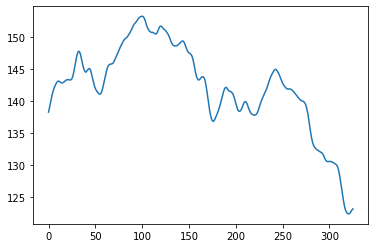

In [24]:
# Plots the predicted test values
plt.plot(y_predicted)
# Plots the true historic close values

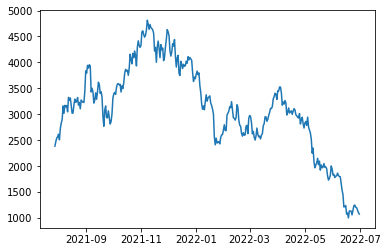

In [25]:
# Plots the true historic close values
plt.plot(df.iloc[760:]['close'])

In [26]:
y[-326]

array([3013.73266602])

SyntaxError: invalid syntax (Temp/ipykernel_13176/2366666683.py, line 1)